In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import glob, os
import pandas as pd
import datetime

In [2]:
# defining functions

In [3]:
def getnodes(collectdir):
    '''takes parent directory of log data, looks like r'170221/ota10_saturationtest1_1702211345/'
    must end with a slash
    returns dictionary where keys = nodes, values = filepaths to those nodes'''
    
    nodes = glob.glob(collectdir + r'data/n*') # list of filepaths to each node in the test
    node_id = [int(n[-3:]) for n in nodes]
    
    return dict(zip(node_id, nodes))

In [4]:
def converttime(date, timestring):
    '''convert timestamps from mgen.log to datetime object in UTC
    date: the day of the experiment (assumes experiment doesn't span multiple days)
    timestring: the timestamp string from mgen.log, looks like "18:46:17.987205"'''
    
    # convert timestring to seconds since midnight
    h, m, s = [float(n) for n in timestring.split(':')]
    sincemidnight = datetime.timedelta(seconds = 3600.*h + 60.*m + s)
    
    return date + sincemidnight

In [5]:
def getmgen(nodedict, date):
    '''takes a dictionary of node filepaths and a date
    nodedict: output of getnodes()
    date: date of the experiment
    returns a dictionary of pandas dataframes, where
    keys = nodes, values = a pandas dataframe representing the mgen log of that node'''
    
    nodes = sorted(nodedict.keys())
    mgen_logs = {}
    
    for n in nodes:
        # read mgen file, if it exists
        if not os.path.isfile(nodedict[n] + r'/mgen.log'):
            mgen_logs[n] = 'no packets received'
            continue
        
        with open(nodedict[n] + r'/mgen.log', 'r') as f:
            lines = [line.strip().split(' ') for line in f if ('RECV' in line) and (len(line.strip().split(' ')) == 10)]
        
        if lines == []: # if no packets received
            mgen_logs[n] = 'no packets received'
            
        else:
            # parse into separate columns
            columns = zip(*lines)

            receivetime  = columns[0]
            protocol = [c[c.find('>') + 1 :] for c in columns[2]]
            flow = [int(c[c.find('>') + 1 :]) for c in columns[3]]
            seq = [c[c.find('>') + 1 :] for c in columns[4]]
            src = [c[c.find('>') + 1 :] for c in columns[5]]
            dst = [c[c.find('>') + 1 :] for c in columns[6]]
            senttime = [c[c.find('>') + 1 :] for c in columns[7]]
            sizeinbytes = [int(c[c.find('>') + 1 :]) for c in columns[8]]

            # convert time columns to datetime objects
            receivetime = [converttime(date, t) for t in receivetime]
            senttime = [converttime(date, t) for t in senttime]

            # generate mgen dataframe
            mgen_logs[n] = pd.DataFrame(data = { 'receive_time' : receivetime,
                                                 'protocol'     : protocol,
                                                 'flow'         : flow,
                                                 'seq'          : seq,
                                                 'src'          : src,
                                                 'dst'          : dst,
                                                 'sent_time'    : senttime,
                                                 'size_in_bytes': sizeinbytes}
                                        )
        
    
    return mgen_logs

In [6]:
def calculatethroughput(log, start, end, increment, window):
    '''calculate moving average of bits received per second
    log = a pandas dataframe representing an mgen log, one of the values output from getmgen
    start = start time (datetime object)
    end = end time (datetime object)
    increment = number of seconds between samples (float)
    window = number of seconds over which to average the throughput - window=120 gets the throughput averaged over the last 2 min
    returns a modified pandas dataframe with a column for the incoming bitrate calculated'''
    
    # construct the time axis
    t = start
    time = []
    
    while t <= end:
        time.append(t)
        t += datetime.timedelta(seconds = increment)
    
    # now calculate throughput at each point in time
    
    receive_bitrate_bps = []
    timewindow = datetime.timedelta(seconds = window)

    for windowend in time:

        windowstart = windowend - timewindow
        
        if windowstart < min(log['receive_time']):
            receive_bitrate_bps += [None]
            
        elif windowend > max(log['receive_time']):
            receive_bitrate_bps += [None]
        
        else:
            afterstart = log[log['receive_time'] > windowstart]
            inwindow = afterstart[afterstart['receive_time'] <= windowend]

            bits_in_window = sum(inwindow['size_in_bytes'])*8. # bits received in the window

            receive_bitrate_bps += [bits_in_window/window]

        
    return pd.DataFrame(data = {'time' : time,
                                'receive_bitrate_bps' : receive_bitrate_bps
                               })

('throughput at end: ', 444637.86666666664)
('maximum throughput: ', 519936.0)


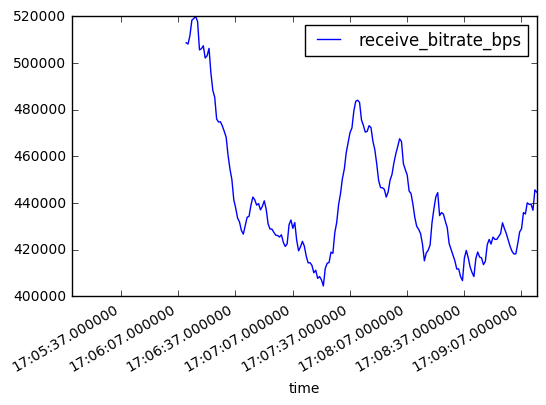

In [7]:
# example run:
# directory corresponding to the experiment we want to get the data for

collectdir = r'170424/deployed/n10/n10_all_calibration_60_1704241304/'
date = datetime.datetime(2017, 4, 24)

nodedirs = getnodes(collectdir)
mgenlogs = getmgen(nodedirs, date)

# combine all mgen logs into one dataframe
mgenlogsall = pd.concat([mgenlogs[i] for i in mgenlogs.keys() if not isinstance(mgenlogs[i], str)])
mgenlogsall = mgenlogsall.sort_values('receive_time').reset_index(drop = True)

# calculate total throughput received at any node, at each second, in the last [window] seconds
window = 60
throughput = calculatethroughput(mgenlogsall, min(mgenlogsall['receive_time']), max(mgenlogsall['receive_time']), 1, window)

# plot throughput as function of time
throughput.set_index('time').plot()
plt.savefig(os.path.join(collectdir, 'throughput.png'), bbox_inches='tight')

# write to file - for some reason this block of code only works when you run it twice
writer = pd.ExcelWriter(os.path.join(collectdir, 'summary.xlsx'))
mgenlogsall.to_excel(writer, "MGENlogs")
throughput.to_excel(writer, "throughput-over-time")

writer = pd.ExcelWriter(os.path.join(collectdir, 'summary.xlsx'))
mgenlogsall.to_excel(writer, "MGENlogs")
throughput.to_excel(writer, "throughput-over-time")

throughputlist = [i for i in throughput['receive_bitrate_bps'] if not pd.isnull(i)]
print('throughput at end: ', throughputlist[-1])
print('maximum throughput: ', max(throughputlist))

('throughput at end: ', 316825.59999999998)
('maximum throughput: ', 607061.33333333337)


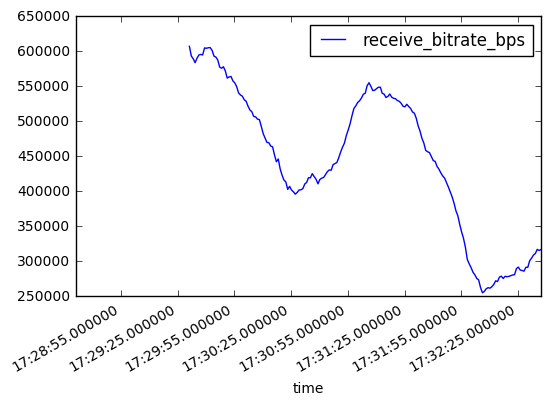

In [8]:
# example run:
# directory corresponding to the experiment we want to get the data for

collectdir = r'170424/deployed/n10/n10_all_calibration_60_1704241327/'
date = datetime.datetime(2017, 4, 24)

nodedirs = getnodes(collectdir)
mgenlogs = getmgen(nodedirs, date)

# combine all mgen logs into one dataframe
mgenlogsall = pd.concat([mgenlogs[i] for i in mgenlogs.keys() if not isinstance(mgenlogs[i], str)])
mgenlogsall = mgenlogsall.sort_values('receive_time').reset_index(drop = True)

# calculate total throughput received at any node, at each second, in the last [window] seconds
window = 60
throughput = calculatethroughput(mgenlogsall, min(mgenlogsall['receive_time']), max(mgenlogsall['receive_time']), 1, window)

# plot throughput as function of time
throughput.set_index('time').plot()
plt.savefig(os.path.join(collectdir, 'throughput.png'), bbox_inches='tight')

# write to file - for some reason this block of code only works when you run it twice
writer = pd.ExcelWriter(os.path.join(collectdir, 'summary.xlsx'))
mgenlogsall.to_excel(writer, "MGENlogs")
throughput.to_excel(writer, "throughput-over-time")

writer = pd.ExcelWriter(os.path.join(collectdir, 'summary.xlsx'))
mgenlogsall.to_excel(writer, "MGENlogs")
throughput.to_excel(writer, "throughput-over-time")

throughputlist = [i for i in throughput['receive_bitrate_bps'] if not pd.isnull(i)]
print('throughput at end: ', throughputlist[-1])
print('maximum throughput: ', max(throughputlist))

('throughput at end: ', 525499.73333333328)
('maximum throughput: ', 641245.8666666667)


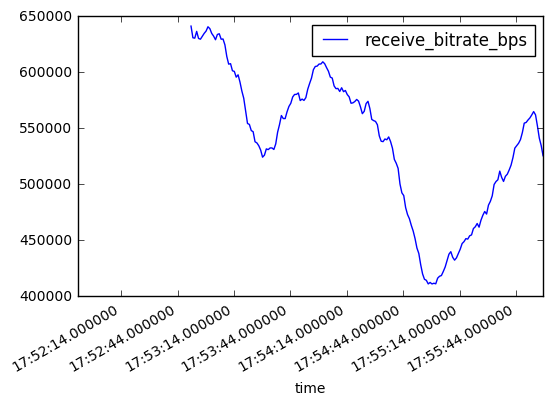

In [9]:
# example run:
# directory corresponding to the experiment we want to get the data for

collectdir = r'170424/deployed/n10/n10_all_calibration_60_1704241351/'
date = datetime.datetime(2017, 4, 24)

nodedirs = getnodes(collectdir)
mgenlogs = getmgen(nodedirs, date)

# combine all mgen logs into one dataframe
mgenlogsall = pd.concat([mgenlogs[i] for i in mgenlogs.keys() if not isinstance(mgenlogs[i], str)])
mgenlogsall = mgenlogsall.sort_values('receive_time').reset_index(drop = True)

# calculate total throughput received at any node, at each second, in the last [window] seconds
window = 60
throughput = calculatethroughput(mgenlogsall, min(mgenlogsall['receive_time']), max(mgenlogsall['receive_time']), 1, window)

# plot throughput as function of time
throughput.set_index('time').plot()
plt.savefig(os.path.join(collectdir, 'throughput.png'), bbox_inches='tight')

# write to file - for some reason this block of code only works when you run it twice
writer = pd.ExcelWriter(os.path.join(collectdir, 'summary.xlsx'))
mgenlogsall.to_excel(writer, "MGENlogs")
throughput.to_excel(writer, "throughput-over-time")

writer = pd.ExcelWriter(os.path.join(collectdir, 'summary.xlsx'))
mgenlogsall.to_excel(writer, "MGENlogs")
throughput.to_excel(writer, "throughput-over-time")

throughputlist = [i for i in throughput['receive_bitrate_bps'] if not pd.isnull(i)]
print('throughput at end: ', throughputlist[-1])
print('maximum throughput: ', max(throughputlist))

('throughput at end: ', 235656.53333333333)
('maximum throughput: ', 553352.53333333333)


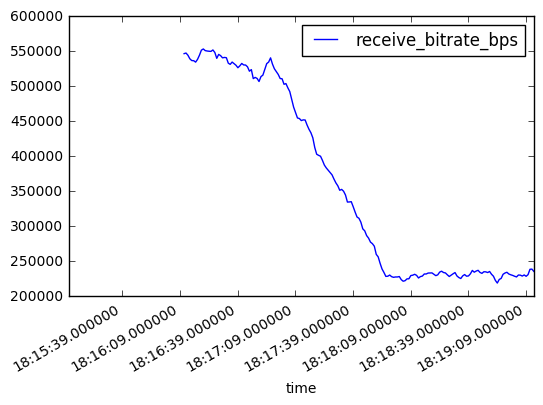

In [10]:
# example run:
# directory corresponding to the experiment we want to get the data for

collectdir = r'170424/deployed/n10/n10_all_calibration_60_1704241414/'
date = datetime.datetime(2017, 4, 24)

nodedirs = getnodes(collectdir)
mgenlogs = getmgen(nodedirs, date)

# combine all mgen logs into one dataframe
mgenlogsall = pd.concat([mgenlogs[i] for i in mgenlogs.keys() if not isinstance(mgenlogs[i], str)])
mgenlogsall = mgenlogsall.sort_values('receive_time').reset_index(drop = True)

# calculate total throughput received at any node, at each second, in the last [window] seconds
window = 60
throughput = calculatethroughput(mgenlogsall, min(mgenlogsall['receive_time']), max(mgenlogsall['receive_time']), 1, window)

# plot throughput as function of time
throughput.set_index('time').plot()
plt.savefig(os.path.join(collectdir, 'throughput.png'), bbox_inches='tight')

# write to file - for some reason this block of code only works when you run it twice
writer = pd.ExcelWriter(os.path.join(collectdir, 'summary.xlsx'))
mgenlogsall.to_excel(writer, "MGENlogs")
throughput.to_excel(writer, "throughput-over-time")

writer = pd.ExcelWriter(os.path.join(collectdir, 'summary.xlsx'))
mgenlogsall.to_excel(writer, "MGENlogs")
throughput.to_excel(writer, "throughput-over-time")

throughputlist = [i for i in throughput['receive_bitrate_bps'] if not pd.isnull(i)]
print('throughput at end: ', throughputlist[-1])
print('maximum throughput: ', max(throughputlist))

('throughput at end: ', 401032.53333333333)
('maximum throughput: ', 425540.26666666666)


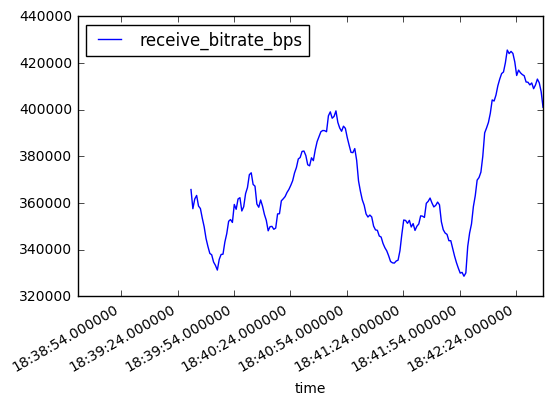

In [11]:
# example run:
# directory corresponding to the experiment we want to get the data for

collectdir = r'170424/deployed/n10/n10_all_calibration_60_1704241437/'
date = datetime.datetime(2017, 4, 24)

nodedirs = getnodes(collectdir)
mgenlogs = getmgen(nodedirs, date)

# combine all mgen logs into one dataframe
mgenlogsall = pd.concat([mgenlogs[i] for i in mgenlogs.keys() if not isinstance(mgenlogs[i], str)])
mgenlogsall = mgenlogsall.sort_values('receive_time').reset_index(drop = True)

# calculate total throughput received at any node, at each second, in the last [window] seconds
window = 60
throughput = calculatethroughput(mgenlogsall, min(mgenlogsall['receive_time']), max(mgenlogsall['receive_time']), 1, window)

# plot throughput as function of time
throughput.set_index('time').plot()
plt.savefig(os.path.join(collectdir, 'throughput.png'), bbox_inches='tight')

# write to file - for some reason this block of code only works when you run it twice
writer = pd.ExcelWriter(os.path.join(collectdir, 'summary.xlsx'))
mgenlogsall.to_excel(writer, "MGENlogs")
throughput.to_excel(writer, "throughput-over-time")

writer = pd.ExcelWriter(os.path.join(collectdir, 'summary.xlsx'))
mgenlogsall.to_excel(writer, "MGENlogs")
throughput.to_excel(writer, "throughput-over-time")

throughputlist = [i for i in throughput['receive_bitrate_bps'] if not pd.isnull(i)]
print('throughput at end: ', throughputlist[-1])
print('maximum throughput: ', max(throughputlist))

('throughput at end: ', 205465.60000000001)
('maximum throughput: ', 339694.93333333335)


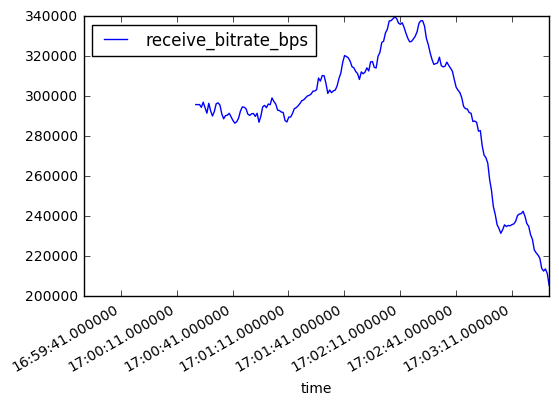

In [12]:
# example run:
# directory corresponding to the experiment we want to get the data for

collectdir = r'170424/deployed/n20/n20_all_calibration_60_1704241258/'
date = datetime.datetime(2017, 4, 24)

nodedirs = getnodes(collectdir)
mgenlogs = getmgen(nodedirs, date)

# combine all mgen logs into one dataframe
mgenlogsall = pd.concat([mgenlogs[i] for i in mgenlogs.keys() if not isinstance(mgenlogs[i], str)])
mgenlogsall = mgenlogsall.sort_values('receive_time').reset_index(drop = True)

# calculate total throughput received at any node, at each second, in the last [window] seconds
window = 60
throughput = calculatethroughput(mgenlogsall, min(mgenlogsall['receive_time']), max(mgenlogsall['receive_time']), 1, window)

# plot throughput as function of time
throughput.set_index('time').plot()
plt.savefig(os.path.join(collectdir, 'throughput.png'), bbox_inches='tight')

# write to file - for some reason this block of code only works when you run it twice
writer = pd.ExcelWriter(os.path.join(collectdir, 'summary.xlsx'))
mgenlogsall.to_excel(writer, "MGENlogs")
throughput.to_excel(writer, "throughput-over-time")

writer = pd.ExcelWriter(os.path.join(collectdir, 'summary.xlsx'))
mgenlogsall.to_excel(writer, "MGENlogs")
throughput.to_excel(writer, "throughput-over-time")

throughputlist = [i for i in throughput['receive_bitrate_bps'] if not pd.isnull(i)]
print('throughput at end: ', throughputlist[-1])
print('maximum throughput: ', max(throughputlist))

('throughput at end: ', 327560.53333333333)
('maximum throughput: ', 410726.40000000002)


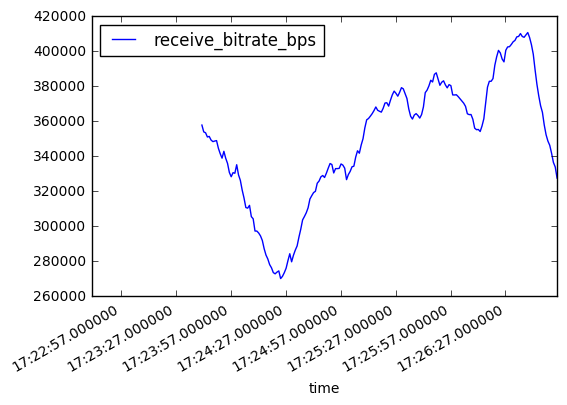

In [13]:
# example run:
# directory corresponding to the experiment we want to get the data for

collectdir = r'170424/deployed/n20/n20_all_calibration_60_1704241321/'
date = datetime.datetime(2017, 4, 24)

nodedirs = getnodes(collectdir)
mgenlogs = getmgen(nodedirs, date)

# combine all mgen logs into one dataframe
mgenlogsall = pd.concat([mgenlogs[i] for i in mgenlogs.keys() if not isinstance(mgenlogs[i], str)])
mgenlogsall = mgenlogsall.sort_values('receive_time').reset_index(drop = True)

# calculate total throughput received at any node, at each second, in the last [window] seconds
window = 60
throughput = calculatethroughput(mgenlogsall, min(mgenlogsall['receive_time']), max(mgenlogsall['receive_time']), 1, window)

# plot throughput as function of time
throughput.set_index('time').plot()
plt.savefig(os.path.join(collectdir, 'throughput.png'), bbox_inches='tight')

# write to file - for some reason this block of code only works when you run it twice
writer = pd.ExcelWriter(os.path.join(collectdir, 'summary.xlsx'))
mgenlogsall.to_excel(writer, "MGENlogs")
throughput.to_excel(writer, "throughput-over-time")

writer = pd.ExcelWriter(os.path.join(collectdir, 'summary.xlsx'))
mgenlogsall.to_excel(writer, "MGENlogs")
throughput.to_excel(writer, "throughput-over-time")

throughputlist = [i for i in throughput['receive_bitrate_bps'] if not pd.isnull(i)]
print('throughput at end: ', throughputlist[-1])
print('maximum throughput: ', max(throughputlist))

('throughput at end: ', 380108.79999999999)
('maximum throughput: ', 559906.1333333333)


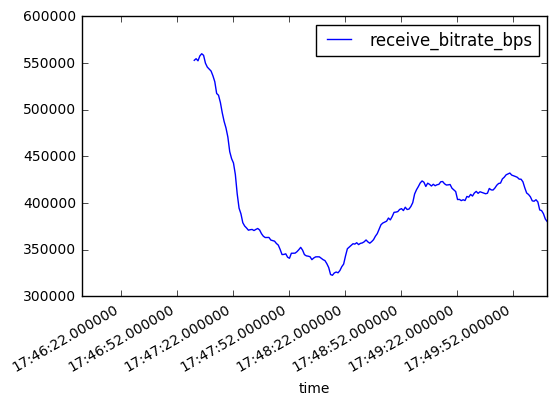

In [14]:
# example run:
# directory corresponding to the experiment we want to get the data for

collectdir = r'170424/deployed/n20/n20_all_calibration_60_1704241345/'
date = datetime.datetime(2017, 4, 24)

nodedirs = getnodes(collectdir)
mgenlogs = getmgen(nodedirs, date)

# combine all mgen logs into one dataframe
mgenlogsall = pd.concat([mgenlogs[i] for i in mgenlogs.keys() if not isinstance(mgenlogs[i], str)])
mgenlogsall = mgenlogsall.sort_values('receive_time').reset_index(drop = True)

# calculate total throughput received at any node, at each second, in the last [window] seconds
window = 60
throughput = calculatethroughput(mgenlogsall, min(mgenlogsall['receive_time']), max(mgenlogsall['receive_time']), 1, window)

# plot throughput as function of time
throughput.set_index('time').plot()
plt.savefig(os.path.join(collectdir, 'throughput.png'), bbox_inches='tight')

# write to file - for some reason this block of code only works when you run it twice
writer = pd.ExcelWriter(os.path.join(collectdir, 'summary.xlsx'))
mgenlogsall.to_excel(writer, "MGENlogs")
throughput.to_excel(writer, "throughput-over-time")

writer = pd.ExcelWriter(os.path.join(collectdir, 'summary.xlsx'))
mgenlogsall.to_excel(writer, "MGENlogs")
throughput.to_excel(writer, "throughput-over-time")

throughputlist = [i for i in throughput['receive_bitrate_bps'] if not pd.isnull(i)]
print('throughput at end: ', throughputlist[-1])
print('maximum throughput: ', max(throughputlist))

('throughput at end: ', 328516.26666666666)
('maximum throughput: ', 479982.93333333335)


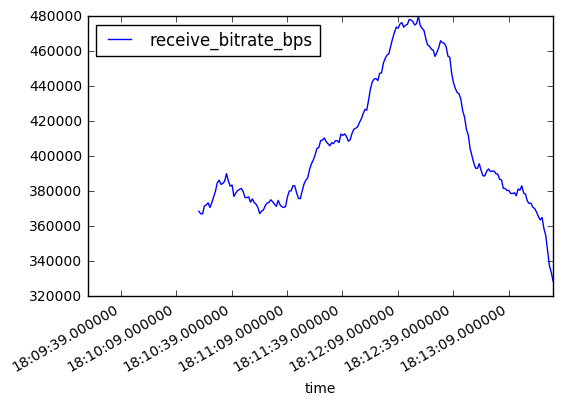

In [15]:
# example run:
# directory corresponding to the experiment we want to get the data for

collectdir = r'170424/deployed/n20/n20_all_calibration_60_1704241408/'
date = datetime.datetime(2017, 4, 24)

nodedirs = getnodes(collectdir)
mgenlogs = getmgen(nodedirs, date)

# combine all mgen logs into one dataframe
mgenlogsall = pd.concat([mgenlogs[i] for i in mgenlogs.keys() if not isinstance(mgenlogs[i], str)])
mgenlogsall = mgenlogsall.sort_values('receive_time').reset_index(drop = True)

# calculate total throughput received at any node, at each second, in the last [window] seconds
window = 60
throughput = calculatethroughput(mgenlogsall, min(mgenlogsall['receive_time']), max(mgenlogsall['receive_time']), 1, window)

# plot throughput as function of time
throughput.set_index('time').plot()
plt.savefig(os.path.join(collectdir, 'throughput.png'), bbox_inches='tight')

# write to file - for some reason this block of code only works when you run it twice
writer = pd.ExcelWriter(os.path.join(collectdir, 'summary.xlsx'))
mgenlogsall.to_excel(writer, "MGENlogs")
throughput.to_excel(writer, "throughput-over-time")

writer = pd.ExcelWriter(os.path.join(collectdir, 'summary.xlsx'))
mgenlogsall.to_excel(writer, "MGENlogs")
throughput.to_excel(writer, "throughput-over-time")

throughputlist = [i for i in throughput['receive_bitrate_bps'] if not pd.isnull(i)]
print('throughput at end: ', throughputlist[-1])
print('maximum throughput: ', max(throughputlist))

('throughput at end: ', 313361.06666666665)
('maximum throughput: ', 381781.33333333331)


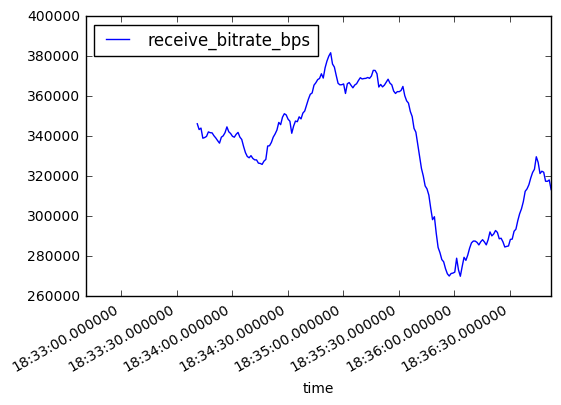

In [16]:
# example run:
# directory corresponding to the experiment we want to get the data for

collectdir = r'170424/deployed/n20/n20_all_calibration_60_1704241431/'
date = datetime.datetime(2017, 4, 24)

nodedirs = getnodes(collectdir)
mgenlogs = getmgen(nodedirs, date)

# combine all mgen logs into one dataframe
mgenlogsall = pd.concat([mgenlogs[i] for i in mgenlogs.keys() if not isinstance(mgenlogs[i], str)])
mgenlogsall = mgenlogsall.sort_values('receive_time').reset_index(drop = True)

# calculate total throughput received at any node, at each second, in the last [window] seconds
window = 60
throughput = calculatethroughput(mgenlogsall, min(mgenlogsall['receive_time']), max(mgenlogsall['receive_time']), 1, window)

# plot throughput as function of time
throughput.set_index('time').plot()
plt.savefig(os.path.join(collectdir, 'throughput.png'), bbox_inches='tight')

# write to file - for some reason this block of code only works when you run it twice
writer = pd.ExcelWriter(os.path.join(collectdir, 'summary.xlsx'))
mgenlogsall.to_excel(writer, "MGENlogs")
throughput.to_excel(writer, "throughput-over-time")

writer = pd.ExcelWriter(os.path.join(collectdir, 'summary.xlsx'))
mgenlogsall.to_excel(writer, "MGENlogs")
throughput.to_excel(writer, "throughput-over-time")

throughputlist = [i for i in throughput['receive_bitrate_bps'] if not pd.isnull(i)]
print('throughput at end: ', throughputlist[-1])
print('maximum throughput: ', max(throughputlist))

('throughput at end: ', 318122.66666666669)
('maximum throughput: ', 347630.93333333335)


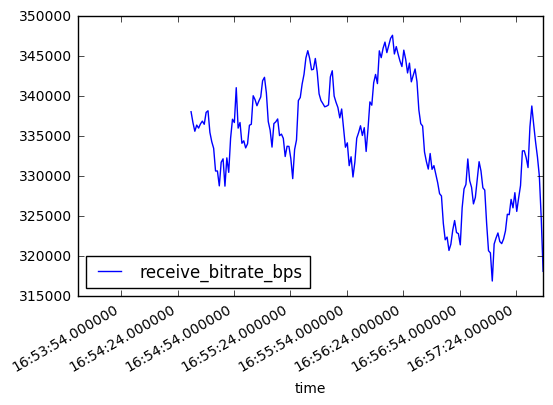

In [17]:
# example run:
# directory corresponding to the experiment we want to get the data for

collectdir = r'170424/deployed/n30/n30_all_calibration_10_1704241252/'
date = datetime.datetime(2017, 4, 24)

nodedirs = getnodes(collectdir)
mgenlogs = getmgen(nodedirs, date)

# combine all mgen logs into one dataframe
mgenlogsall = pd.concat([mgenlogs[i] for i in mgenlogs.keys() if not isinstance(mgenlogs[i], str)])
mgenlogsall = mgenlogsall.sort_values('receive_time').reset_index(drop = True)

# calculate total throughput received at any node, at each second, in the last [window] seconds
window = 60
throughput = calculatethroughput(mgenlogsall, min(mgenlogsall['receive_time']), max(mgenlogsall['receive_time']), 1, window)

# plot throughput as function of time
throughput.set_index('time').plot()
plt.savefig(os.path.join(collectdir, 'throughput.png'), bbox_inches='tight')

# write to file - for some reason this block of code only works when you run it twice
writer = pd.ExcelWriter(os.path.join(collectdir, 'summary.xlsx'))
mgenlogsall.to_excel(writer, "MGENlogs")
throughput.to_excel(writer, "throughput-over-time")

writer = pd.ExcelWriter(os.path.join(collectdir, 'summary.xlsx'))
mgenlogsall.to_excel(writer, "MGENlogs")
throughput.to_excel(writer, "throughput-over-time")

throughputlist = [i for i in throughput['receive_bitrate_bps'] if not pd.isnull(i)]
print('throughput at end: ', throughputlist[-1])
print('maximum throughput: ', max(throughputlist))

('throughput at end: ', 383982.93333333335)
('maximum throughput: ', 450474.66666666669)


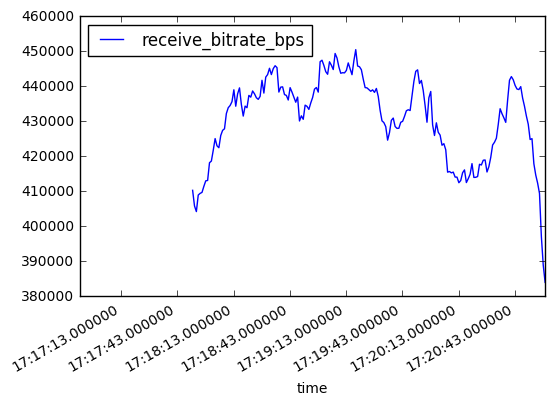

In [18]:
# example run:
# directory corresponding to the experiment we want to get the data for

collectdir = r'170424/deployed/n30/n30_all_calibration_10_1704241316/'
date = datetime.datetime(2017, 4, 24)

nodedirs = getnodes(collectdir)
mgenlogs = getmgen(nodedirs, date)

# combine all mgen logs into one dataframe
mgenlogsall = pd.concat([mgenlogs[i] for i in mgenlogs.keys() if not isinstance(mgenlogs[i], str)])
mgenlogsall = mgenlogsall.sort_values('receive_time').reset_index(drop = True)

# calculate total throughput received at any node, at each second, in the last [window] seconds
window = 60
throughput = calculatethroughput(mgenlogsall, min(mgenlogsall['receive_time']), max(mgenlogsall['receive_time']), 1, window)

# plot throughput as function of time
throughput.set_index('time').plot()
plt.savefig(os.path.join(collectdir, 'throughput.png'), bbox_inches='tight')

# write to file - for some reason this block of code only works when you run it twice
writer = pd.ExcelWriter(os.path.join(collectdir, 'summary.xlsx'))
mgenlogsall.to_excel(writer, "MGENlogs")
throughput.to_excel(writer, "throughput-over-time")

writer = pd.ExcelWriter(os.path.join(collectdir, 'summary.xlsx'))
mgenlogsall.to_excel(writer, "MGENlogs")
throughput.to_excel(writer, "throughput-over-time")

throughputlist = [i for i in throughput['receive_bitrate_bps'] if not pd.isnull(i)]
print('throughput at end: ', throughputlist[-1])
print('maximum throughput: ', max(throughputlist))

('throughput at end: ', 383726.93333333335)
('maximum throughput: ', 446225.06666666665)


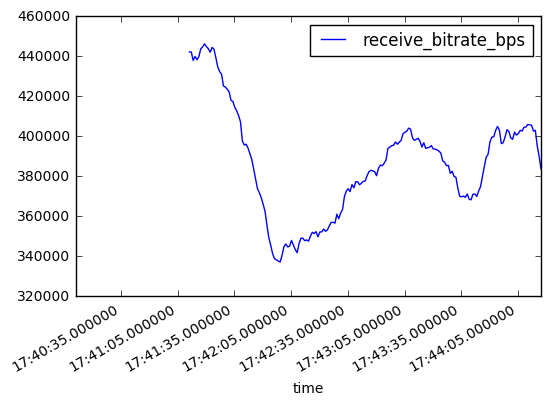

In [19]:
# example run:
# directory corresponding to the experiment we want to get the data for

collectdir = r'170424/deployed/n30/n30_all_calibration_10_1704241339/'
date = datetime.datetime(2017, 4, 24)

nodedirs = getnodes(collectdir)
mgenlogs = getmgen(nodedirs, date)

# combine all mgen logs into one dataframe
mgenlogsall = pd.concat([mgenlogs[i] for i in mgenlogs.keys() if not isinstance(mgenlogs[i], str)])
mgenlogsall = mgenlogsall.sort_values('receive_time').reset_index(drop = True)

# calculate total throughput received at any node, at each second, in the last [window] seconds
window = 60
throughput = calculatethroughput(mgenlogsall, min(mgenlogsall['receive_time']), max(mgenlogsall['receive_time']), 1, window)

# plot throughput as function of time
throughput.set_index('time').plot()
plt.savefig(os.path.join(collectdir, 'throughput.png'), bbox_inches='tight')

# write to file - for some reason this block of code only works when you run it twice
writer = pd.ExcelWriter(os.path.join(collectdir, 'summary.xlsx'))
mgenlogsall.to_excel(writer, "MGENlogs")
throughput.to_excel(writer, "throughput-over-time")

writer = pd.ExcelWriter(os.path.join(collectdir, 'summary.xlsx'))
mgenlogsall.to_excel(writer, "MGENlogs")
throughput.to_excel(writer, "throughput-over-time")

throughputlist = [i for i in throughput['receive_bitrate_bps'] if not pd.isnull(i)]
print('throughput at end: ', throughputlist[-1])
print('maximum throughput: ', max(throughputlist))

('throughput at end: ', 360174.93333333335)
('maximum throughput: ', 445320.53333333333)


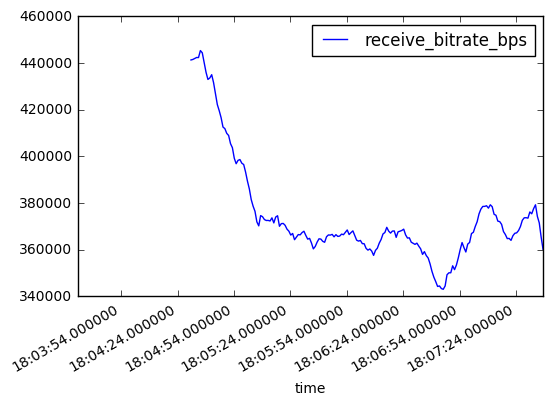

In [20]:
# example run:
# directory corresponding to the experiment we want to get the data for

collectdir = r'170424/deployed/n30/n30_all_calibration_10_1704241402/'
date = datetime.datetime(2017, 4, 24)

nodedirs = getnodes(collectdir)
mgenlogs = getmgen(nodedirs, date)

# combine all mgen logs into one dataframe
mgenlogsall = pd.concat([mgenlogs[i] for i in mgenlogs.keys() if not isinstance(mgenlogs[i], str)])
mgenlogsall = mgenlogsall.sort_values('receive_time').reset_index(drop = True)

# calculate total throughput received at any node, at each second, in the last [window] seconds
window = 60
throughput = calculatethroughput(mgenlogsall, min(mgenlogsall['receive_time']), max(mgenlogsall['receive_time']), 1, window)

# plot throughput as function of time
throughput.set_index('time').plot()
plt.savefig(os.path.join(collectdir, 'throughput.png'), bbox_inches='tight')

# write to file - for some reason this block of code only works when you run it twice
writer = pd.ExcelWriter(os.path.join(collectdir, 'summary.xlsx'))
mgenlogsall.to_excel(writer, "MGENlogs")
throughput.to_excel(writer, "throughput-over-time")

writer = pd.ExcelWriter(os.path.join(collectdir, 'summary.xlsx'))
mgenlogsall.to_excel(writer, "MGENlogs")
throughput.to_excel(writer, "throughput-over-time")

throughputlist = [i for i in throughput['receive_bitrate_bps'] if not pd.isnull(i)]
print('throughput at end: ', throughputlist[-1])
print('maximum throughput: ', max(throughputlist))

('throughput at end: ', 325034.66666666669)
('maximum throughput: ', 463001.59999999998)


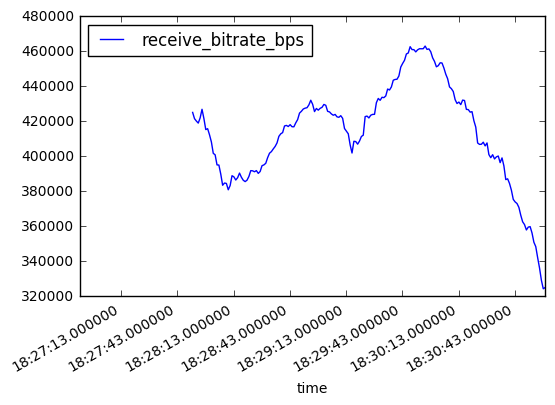

In [21]:
# example run:
# directory corresponding to the experiment we want to get the data for

collectdir = r'170424/deployed/n30/n30_all_calibration_10_1704241426/'
date = datetime.datetime(2017, 4, 24)

nodedirs = getnodes(collectdir)
mgenlogs = getmgen(nodedirs, date)

# combine all mgen logs into one dataframe
mgenlogsall = pd.concat([mgenlogs[i] for i in mgenlogs.keys() if not isinstance(mgenlogs[i], str)])
mgenlogsall = mgenlogsall.sort_values('receive_time').reset_index(drop = True)

# calculate total throughput received at any node, at each second, in the last [window] seconds
window = 60
throughput = calculatethroughput(mgenlogsall, min(mgenlogsall['receive_time']), max(mgenlogsall['receive_time']), 1, window)

# plot throughput as function of time
throughput.set_index('time').plot()
plt.savefig(os.path.join(collectdir, 'throughput.png'), bbox_inches='tight')

# write to file - for some reason this block of code only works when you run it twice
writer = pd.ExcelWriter(os.path.join(collectdir, 'summary.xlsx'))
mgenlogsall.to_excel(writer, "MGENlogs")
throughput.to_excel(writer, "throughput-over-time")

writer = pd.ExcelWriter(os.path.join(collectdir, 'summary.xlsx'))
mgenlogsall.to_excel(writer, "MGENlogs")
throughput.to_excel(writer, "throughput-over-time")

throughputlist = [i for i in throughput['receive_bitrate_bps'] if not pd.isnull(i)]
print('throughput at end: ', throughputlist[-1])
print('maximum throughput: ', max(throughputlist))

('throughput at end: ', 387686.40000000002)
('maximum throughput: ', 470340.26666666666)


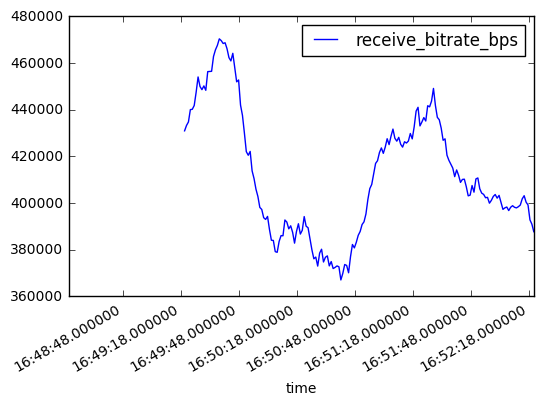

In [22]:
# example run:
# directory corresponding to the experiment we want to get the data for

collectdir = r'170424/deployed/n40/n40_all_calibration_10_1704241246/'
date = datetime.datetime(2017, 4, 24)

nodedirs = getnodes(collectdir)
mgenlogs = getmgen(nodedirs, date)

# combine all mgen logs into one dataframe
mgenlogsall = pd.concat([mgenlogs[i] for i in mgenlogs.keys() if not isinstance(mgenlogs[i], str)])
mgenlogsall = mgenlogsall.sort_values('receive_time').reset_index(drop = True)

# calculate total throughput received at any node, at each second, in the last [window] seconds
window = 60
throughput = calculatethroughput(mgenlogsall, min(mgenlogsall['receive_time']), max(mgenlogsall['receive_time']), 1, window)

# plot throughput as function of time
throughput.set_index('time').plot()
plt.savefig(os.path.join(collectdir, 'throughput.png'), bbox_inches='tight')

# write to file - for some reason this block of code only works when you run it twice
writer = pd.ExcelWriter(os.path.join(collectdir, 'summary.xlsx'))
mgenlogsall.to_excel(writer, "MGENlogs")
throughput.to_excel(writer, "throughput-over-time")

writer = pd.ExcelWriter(os.path.join(collectdir, 'summary.xlsx'))
mgenlogsall.to_excel(writer, "MGENlogs")
throughput.to_excel(writer, "throughput-over-time")

throughputlist = [i for i in throughput['receive_bitrate_bps'] if not pd.isnull(i)]
print('throughput at end: ', throughputlist[-1])
print('maximum throughput: ', max(throughputlist))

('throughput at end: ', 436155.73333333334)
('maximum throughput: ', 480000.0)


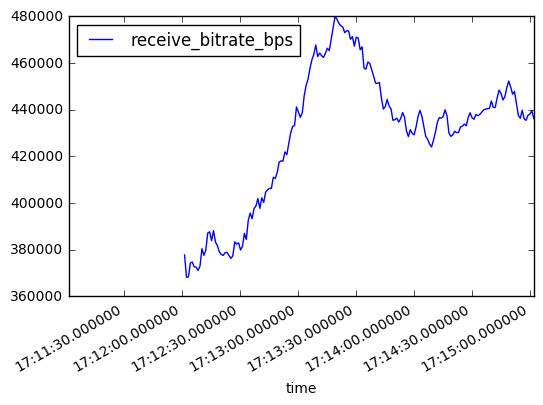

In [23]:
# example run:
# directory corresponding to the experiment we want to get the data for

collectdir = r'170424/deployed/n40/n40_all_calibration_10_1704241310/'
date = datetime.datetime(2017, 4, 24)

nodedirs = getnodes(collectdir)
mgenlogs = getmgen(nodedirs, date)

# combine all mgen logs into one dataframe
mgenlogsall = pd.concat([mgenlogs[i] for i in mgenlogs.keys() if not isinstance(mgenlogs[i], str)])
mgenlogsall = mgenlogsall.sort_values('receive_time').reset_index(drop = True)

# calculate total throughput received at any node, at each second, in the last [window] seconds
window = 60
throughput = calculatethroughput(mgenlogsall, min(mgenlogsall['receive_time']), max(mgenlogsall['receive_time']), 1, window)

# plot throughput as function of time
throughput.set_index('time').plot()
plt.savefig(os.path.join(collectdir, 'throughput.png'), bbox_inches='tight')

# write to file - for some reason this block of code only works when you run it twice
writer = pd.ExcelWriter(os.path.join(collectdir, 'summary.xlsx'))
mgenlogsall.to_excel(writer, "MGENlogs")
throughput.to_excel(writer, "throughput-over-time")

writer = pd.ExcelWriter(os.path.join(collectdir, 'summary.xlsx'))
mgenlogsall.to_excel(writer, "MGENlogs")
throughput.to_excel(writer, "throughput-over-time")

throughputlist = [i for i in throughput['receive_bitrate_bps'] if not pd.isnull(i)]
print('throughput at end: ', throughputlist[-1])
print('maximum throughput: ', max(throughputlist))

('throughput at end: ', 380637.86666666664)
('maximum throughput: ', 442658.13333333336)


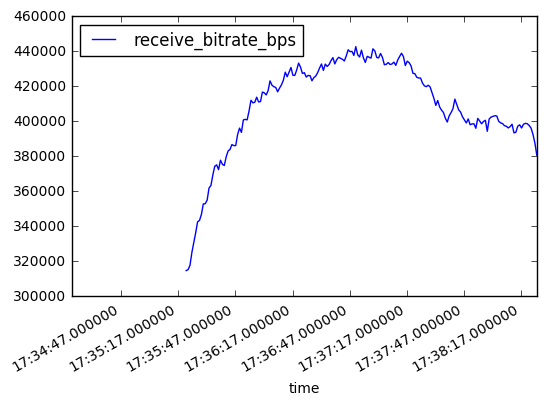

In [24]:
# example run:
# directory corresponding to the experiment we want to get the data for

collectdir = r'170424/deployed/n40/n40_all_calibration_10_1704241333/'
date = datetime.datetime(2017, 4, 24)

nodedirs = getnodes(collectdir)
mgenlogs = getmgen(nodedirs, date)

# combine all mgen logs into one dataframe
mgenlogsall = pd.concat([mgenlogs[i] for i in mgenlogs.keys() if not isinstance(mgenlogs[i], str)])
mgenlogsall = mgenlogsall.sort_values('receive_time').reset_index(drop = True)

# calculate total throughput received at any node, at each second, in the last [window] seconds
window = 60
throughput = calculatethroughput(mgenlogsall, min(mgenlogsall['receive_time']), max(mgenlogsall['receive_time']), 1, window)

# plot throughput as function of time
throughput.set_index('time').plot()
plt.savefig(os.path.join(collectdir, 'throughput.png'), bbox_inches='tight')

# write to file - for some reason this block of code only works when you run it twice
writer = pd.ExcelWriter(os.path.join(collectdir, 'summary.xlsx'))
mgenlogsall.to_excel(writer, "MGENlogs")
throughput.to_excel(writer, "throughput-over-time")

writer = pd.ExcelWriter(os.path.join(collectdir, 'summary.xlsx'))
mgenlogsall.to_excel(writer, "MGENlogs")
throughput.to_excel(writer, "throughput-over-time")

throughputlist = [i for i in throughput['receive_bitrate_bps'] if not pd.isnull(i)]
print('throughput at end: ', throughputlist[-1])
print('maximum throughput: ', max(throughputlist))

('throughput at end: ', 445969.06666666665)
('maximum throughput: ', 544972.80000000005)


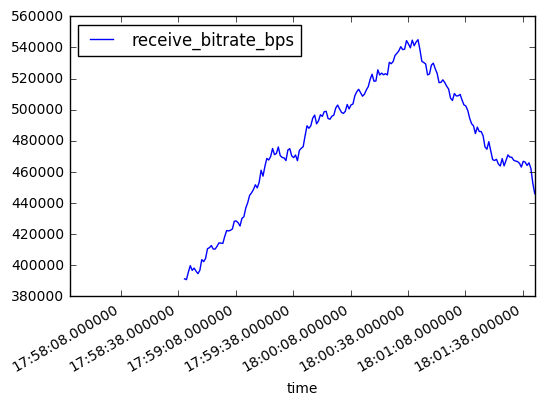

In [25]:
# example run:
# directory corresponding to the experiment we want to get the data for

collectdir = r'170424/deployed/n40/n40_all_calibration_10_1704241356/'
date = datetime.datetime(2017, 4, 24)

nodedirs = getnodes(collectdir)
mgenlogs = getmgen(nodedirs, date)

# combine all mgen logs into one dataframe
mgenlogsall = pd.concat([mgenlogs[i] for i in mgenlogs.keys() if not isinstance(mgenlogs[i], str)])
mgenlogsall = mgenlogsall.sort_values('receive_time').reset_index(drop = True)

# calculate total throughput received at any node, at each second, in the last [window] seconds
window = 60
throughput = calculatethroughput(mgenlogsall, min(mgenlogsall['receive_time']), max(mgenlogsall['receive_time']), 1, window)

# plot throughput as function of time
throughput.set_index('time').plot()
plt.savefig(os.path.join(collectdir, 'throughput.png'), bbox_inches='tight')

# write to file - for some reason this block of code only works when you run it twice
writer = pd.ExcelWriter(os.path.join(collectdir, 'summary.xlsx'))
mgenlogsall.to_excel(writer, "MGENlogs")
throughput.to_excel(writer, "throughput-over-time")

writer = pd.ExcelWriter(os.path.join(collectdir, 'summary.xlsx'))
mgenlogsall.to_excel(writer, "MGENlogs")
throughput.to_excel(writer, "throughput-over-time")

throughputlist = [i for i in throughput['receive_bitrate_bps'] if not pd.isnull(i)]
print('throughput at end: ', throughputlist[-1])
print('maximum throughput: ', max(throughputlist))

('throughput at end: ', 446788.26666666666)
('maximum throughput: ', 510259.20000000001)


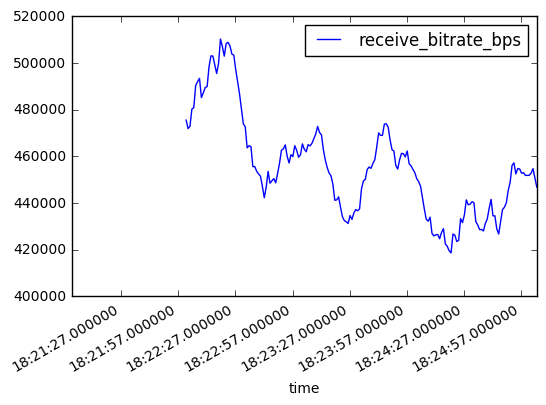

In [26]:
# example run:
# directory corresponding to the experiment we want to get the data for

collectdir = r'170424/deployed/n40/n40_all_calibration_10_1704241420/'
date = datetime.datetime(2017, 4, 24)

nodedirs = getnodes(collectdir)
mgenlogs = getmgen(nodedirs, date)

# combine all mgen logs into one dataframe
mgenlogsall = pd.concat([mgenlogs[i] for i in mgenlogs.keys() if not isinstance(mgenlogs[i], str)])
mgenlogsall = mgenlogsall.sort_values('receive_time').reset_index(drop = True)

# calculate total throughput received at any node, at each second, in the last [window] seconds
window = 60
throughput = calculatethroughput(mgenlogsall, min(mgenlogsall['receive_time']), max(mgenlogsall['receive_time']), 1, window)

# plot throughput as function of time
throughput.set_index('time').plot()
plt.savefig(os.path.join(collectdir, 'throughput.png'), bbox_inches='tight')

# write to file - for some reason this block of code only works when you run it twice
writer = pd.ExcelWriter(os.path.join(collectdir, 'summary.xlsx'))
mgenlogsall.to_excel(writer, "MGENlogs")
throughput.to_excel(writer, "throughput-over-time")

writer = pd.ExcelWriter(os.path.join(collectdir, 'summary.xlsx'))
mgenlogsall.to_excel(writer, "MGENlogs")
throughput.to_excel(writer, "throughput-over-time")

throughputlist = [i for i in throughput['receive_bitrate_bps'] if not pd.isnull(i)]
print('throughput at end: ', throughputlist[-1])
print('maximum throughput: ', max(throughputlist))